In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import gc
import glob
#os.environ['QT_QPA_PLATFORM']='offscreen' #Necessaire pour utiliser ipython en interactif hors du CNRM, sinon erreur avec le Display
import sys
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import climpred
from climpred import HindcastEnsemble
from functools import partial
import xarray as xr
import xesmf as xe
import xskillscore as xs
import readnc_tools as rd
import readnc2_tools as rd2
import plot_tools as pt

pathin="/cnrm/pastel/USERS/ardilouzec/ncdf/S2S/"
pathobs="/cnrm/pastel/DATA/REF/era5/ncdf/daily/"

#List of forecast dates of available netcdf files per model
def get_date_list(model):
    toto=sorted([datetime.strptime(f[-11:-3],'%Y%m%d') for f in glob.glob(pathin+model+'/*t2m_????????.nc')])
    return toto

#Subsample the list of forecast dates so as to take the last date of february and the 11 following ones for each year. !!!! SHOULD NOT BE APPLIED TO BOM (forecast date frequency higher than weekly) !!
def subsample_dates(list_dates):
    subsample=[]
    for y in range(1996,2014):
     d=[x for x in list_dates if x.month==2 and x.year==y][-1] #last February date of each year
     index=list_dates.index(d)
     subsample=subsample+list_dates[index:index+12]
    return subsample

def prepro(ds,fic,d):
        filename=ds.encoding["source"]
        fic.sort()
        idx=fic.index(filename)
        new_init=d[idx]
        ds=ds.reindex({"time":pd.date_range(new_init,ds.time[-1].values)},method='bfill')
        ds   = ds.rename({'number': 'member','latitude': 'lat','longitude': 'lon'})
        #ds['time'] = ds['time'].get_index('time')+timedelta(hours=12)
        init = ds.time[0]
        ds   = ds.isel(time=slice(None,42),member=slice(None,10))

        ### Lead coordinate
        lead = range(0, ds.time.size)
        ds   = ds.assign_coords({'time': lead})
        ds   = ds.rename({'time': 'lead'})

        ### Init coordinate
        ds   = ds.assign_coords({'init': init})
        ds   = ds.expand_dims(dim = 'init')

        ### Member coordinate
        ds   = ds.assign_coords({'member': range(1,11)})
        ### Regridding
        ds_out = xr.Dataset(
        {
        "lat": (["lat"], np.arange(-90, 91.5, 1.5)),
        "lon": (["lon"], np.arange(0, 360, 1.5)),
        })

        regridder = xe.Regridder(ds, ds_out, "bilinear", periodic=True)
        ds_out = regridder(ds)
        ds=ds_out
        ds['lead'].attrs['units'] = 'days'
        ### Clean
        ds.attrs.clear()
        coords  = list(ds.coords)
        keep    = ['lead', 'lon', 'lat', 'member', 'init','sdepth']
        if 'sdepth' in coords:
            ds   = ds.rename({'sdepth': 'depth'})
        for kp in keep:
            if kp in coords:
              coords.remove(kp)

        out = ds.sortby('lat').drop(coords)
        return out

def model(x):
    return {
      'BOM':bom_d,
      'ECMWF':ecmwf_d,
      'HMCR':hmcr_d,
      'CNRM':cnrm_d,
    }[x]
def period(x):
    return {
      0:'Early spring',
      1:'Mid spring',
      2:'Late spring',
    }[x]
#Compute anomalies
def hind_anomaly(ds):
 dsanom=ds.isel(init=slice(0,216,12))-ds.isel(init=slice(0,216,12)).mean(['init','member'])
 for i in range(1,12): 
    dsanom=xr.concat([dsanom,ds.isel(init=slice(i,216,12))-ds.isel(init=slice(i,216,12)).mean(['init','member'])],dim='init')
 dsanom=dsanom.sortby('init')
 return(dsanom)

<frozen importlib._bootstrap>:219: UserWarning: PROJ 8+ is required. Current version: 7.2.0


In [11]:
models=['BOM','CNRM','ECMWF','HMCR']

cnrm_dates=get_date_list('CNRM')
ecmwf_dates=get_date_list('ECMWF')
hmcr_dates=get_date_list('HMCR')
bom_dates=get_date_list('BOM')
ecmwf_d=subsample_dates(ecmwf_dates)
hmcr_d=subsample_dates(hmcr_dates)
cnrm_d=subsample_dates(cnrm_dates)
bom_d=[min(bom_dates,key=lambda sub: abs(sub - x)) for x in ecmwf_d ] #Subsamble BOM forecast dates by minimizing the difference with ecmwf dates
#La fonction suivante crée des doublons dans cnrm_d donc on oublie
#cnrm_d=[min(cnrm_dates,key=lambda sub: abs(sub - x)) for x in ecmwf_d ]

d=[] #date la plus précoce parmi les 4 modèles pour chaque start date
for i in range(len(bom_d)):
 d.append(min([bom_d[i],cnrm_d[i],ecmwf_d[i],hmcr_d[i]]))


ref='era5'
variables=['t2m']
lat_lims = [30,90]
obs=rd.read_ref(pathobs,variables,ref)
obs=obs.groupby("time.dayofyear")-obs.groupby("time.dayofyear").mean("time")
levels = [-1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

#Creer une fonction pour merger les 4 datasets sur la dimension "member"
def merge_ds(models,var):
 liste=[]
 for mod in models:
  fic=[ f for f in glob.glob(pathin+mod+'/*'+var+'_????????.nc') if (datetime.strptime(f[-11:-3],'%Y%m%d') in model(mod)) ]
  partial_func = partial(prepro, fic=fic, d=d)
  ds= xr.open_mfdataset(fic,preprocess = partial_func)
  ds= ds.chunk({'member':1,'lon':60})
  ds=hind_anomaly(ds)
  liste.append(ds)
 ds_out=xr.concat(liste,dim="member")
 ds_out=ds_out.assign_coords({"member":range(len(ds_out.member))}).chunk({'member':1,'lon':60})
 return(ds_out)


##############################"
def plot_corr(ds,nyear,ini,threshold): #ini = 0 pour early spring, 1 pour MId Spring ou 2 pour Late spring  
  a=ds.sel(init=ds.init[ini*4:ini*4+4])
  for y in range(1,nyear):
   a=xr.concat([a,ds.sel(init=ds.init[12*y+ini*4:12*y+ini*4+4])],dim='init')
  ds=a.mean(dim=['member'])
  del a
  ds.attrs['model']='Multi-model'
  hins2s=HindcastEnsemble(ds.chunk({'init':-1}))
  hins2s=hins2s.add_observations(obs.chunk({'time':-1})).compute()
  a=hins2s.smooth(dict(lead=7), how="mean").verify(metric="pearson_r",comparison="e2o",alignment="same_inits",dim=["init"]).sel(lead=["4-10","11-17","18-24","25-31"])
  pval=hins2s.smooth(dict(lead=7), how="mean").verify(metric="pearson_r_eff_p_value",comparison="e2o",alignment="same_inits",dim=["init"]).sel(lead=["4-10","11-17","18-24","25-31"])
  
  plt.rcParams.update({'axes.titlesize': 'small'})                                                          
  p=a.to_array()[0,:,:,:].plot.imshow(x='lon',y='lat',col='lead',cmap='viridis',robust=True,levels=levels, transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.NorthPolarStereo()))
  b=a.where(pval<=threshold)  
  for i,ax in enumerate(p.axes.flat):
   b.to_array()[0,i,:,:].plot.contourf('lon','lat',ax=ax,colors='None',add_colorbar=False,hatches=[3*'.'],transform=ccrs.PlateCarree(),alpha=0)
   pt.polarCentral_set_latlim(lat_lims,ax)
   ax.coastlines()
   ax.set_title('lead='+str(a.lead[i].values))
  p.fig.suptitle('Multi-model'+' '+period(ini),y=1.05)
  plt.show()
                                                      
 #for i,ax in enumerate(p.axes.flat):
 #  b=a.to_array()[0,i,:,:]<0.4
 #  b.plot.contourf('lon','lat',ax=ax,colors='None',add_colorbar=False,levels=3,hatches=['',4*'/'],transform=ccrs.PlateCarree(),alpha=0.1)
 #  pt.polarCentral_set_latlim(lat_lims,ax)
 #  ax.coastlines()
 #  ax.set_title('lead='+str(a.lead[i].values))
 # p.fig.suptitle('Multi-model'+' '+period(ini))
 # plt.show()

In [13]:
for var in variables:
 ds=merge_ds(models,var)

In [14]:
ds

,Array,Chunk
Bytes,39.26 GiB,1.16 MiB
Shape,"(216, 42, 40, 121, 240)","(1, 42, 1, 121, 60)"
Count,484230 Tasks,34560 Chunks
Type,float32,numpy.ndarray


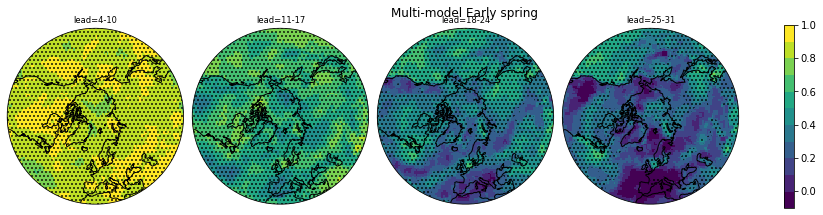

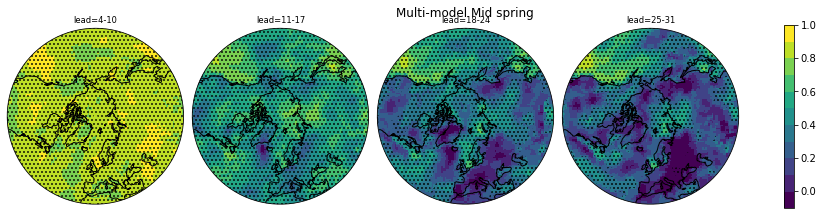

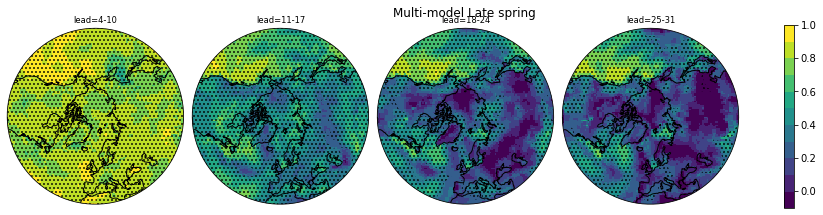

In [15]:
for var in variables: 
 for i in range(3):
  plot_corr(ds,18,i,0.05) #Arguments: ds=input dataset, 18=Nb of years, i=0,1 or 2 (early, mid or late season) and 0.05=significance threshold for the correlation